In [10]:
import numpy as np
import matplotlib.pyplot as plt

def build_vocab(text):
    chars = sorted(list(set(text)))
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for ch, i in stoi.items()}
    return chars, stoi, itos

def text_to_indices(text, stoi):
    return np.array([stoi[ch] for ch in text], dtype=np.int32)

def init_reservoir(n_in, n_res, density, spectral_radius, input_scale, seed):
    """
    Initialize reservoir weights and input weights

    Args:
        n_in: number of input units
        n_res: number of reservoir units
        density: density of reservoir weight matrix
        spectral_radius: desired spectral radius of reservoir weight matrix
        input_scale: scaling factor for input weights
        seed: random seed for reproducibility
    """

    rng = np.random.default_rng(seed)
    # Input weights include bias; shape: n_res x (1 + n_in)
    Win = (rng.standard_normal((n_res, 1 + n_in)).astype(np.float32)) * input_scale
    # Reservoir weights sparse-ish dense matrix
    W = np.zeros((n_res, n_res), dtype=np.float32)
    nnz = int(density * n_res * n_res) # number of non-zero entries
    idx_i = rng.integers(0, n_res, size=nnz) # row indices
    idx_j = rng.integers(0, n_res, size=nnz) # column indices
    vals = rng.standard_normal(nnz).astype(np.float32) # weights
    W[idx_i, idx_j] = vals
    # Scale to desired spectral radius
    eigvals = np.linalg.eigvals(W.astype(np.float64))
    sr = np.max(np.abs(eigvals)).real
    if sr > 0:
        W *= (spectral_radius / sr)
    return Win, W

def rls_init(n_feat, reg):
    # P ~ (1/reg) * I; larger 1/reg means weaker prior (more plastic)
    P = (1.0 / reg) * np.eye(n_feat, dtype=np.float32)
    return P

def run_esn_training(
    indices,
    vocab_size,
    Win, W,
    alpha=0.3,
    washout=100,
    reg=1.0,
    loss_chunk=1000,
    include_input_in_readout=True,
    seed=42,
):
    """
    Args:
        indices: array of integer indices representing the training text
        vocab_size: size of the vocabulary (number of unique characters)
        Win: input weight matrix (n_res x (1 + n_in))
        W: reservoir weight matrix (n_res x n_res)
        alpha: leaking rate
        washout: number of initial time steps to discard for reservoir settling
        reg: regularization parameter for RLS
        loss_chunk: number of steps to average loss over for reporting
        include_input_in_readout: whether to include input in readout features
        seed: random seed for reproducibility
    """
    rng = np.random.default_rng(seed)
    n_res = W.shape[0]
    n_in = vocab_size
    n_out = vocab_size

    # One-hot lookup
    I = np.eye(vocab_size, dtype=np.float32)

    # Reservoir state
    x = np.zeros(n_res, dtype=np.float32)

    # Feature vector z = [1, u, x] or [1, x]
    if include_input_in_readout:
        n_feat = 1 + n_in + n_res
    else:
        n_feat = 1 + n_res

    # Readout
    Wout = np.zeros((n_out, n_feat), dtype=np.float32)

    # RLS inverse correlation matrix
    P = rls_init(n_feat, reg=reg)

    # Loss tracking
    losses = []
    chunk_losses = []
    steps_seen = 0

    # Training loop (teacher forcing), using all pairs (t -> t+1) after washout
    # We will update P and Wout only after washout
    T = len(indices) - 1
    bias = np.array([1.0], dtype=np.float32)

    for t in range(T):
        u_idx = indices[t]
        v_idx = indices[t + 1]

        u = I[u_idx]  # one-hot current
        v = I[v_idx]  # one-hot next

        # Reservoir update: x <- (1 - alpha) * x + alpha * tanh( Win @ [1; u] + W @ x )
        in_vec = np.concatenate([bias, u], dtype=np.float32)  # shape 1 + n_in
        preact = Win @ in_vec + W @ x
        x = (1.0 - alpha) * x + alpha * np.tanh(preact)

        # Feature vector
        if include_input_in_readout:
            z = np.concatenate([bias, u, x], dtype=np.float32)  # shape n_feat
        else:
            z = np.concatenate([bias, x], dtype=np.float32)

        # Predict
        y_pred = Wout @ z  # linear logits for each char

        # Compute MSE loss vs one-hot target
        err = v - y_pred
        mse = np.mean(err * err)
        # During washout, just track reservoir settling; no RLS updates
        if t >= washout:
            # RLS update
            # k = P z / (1 + z^T P z)
            Pz = P @ z
            denom = 1.0 + float(z @ Pz)
            k = Pz / denom  # shape (n_feat,)

            # Wout <- Wout + (v - y_pred) k^T
            # Broadcasting outer product for multi-output
            Wout += np.outer(err, k).astype(np.float32)

            # P <- P - k (z^T P)
            P -= np.outer(k, Pz).astype(np.float32)

            # record loss
            chunk_losses.append(mse)
            steps_seen += 1
            if steps_seen % loss_chunk == 0:
                losses.append(float(np.mean(chunk_losses)))
                chunk_losses = []

    # If last partial chunk exists, record it
    if len(chunk_losses) > 0:
        losses.append(float(np.mean(chunk_losses)))

    return Wout, losses

def evaluate_accuracy(indices, vocab_size, Win, W, Wout, alpha=0.3, include_input_in_readout=True):
    # Teacher forcing evaluation: predict next char from current char and current state
    n_res = W.shape[0]
    I = np.eye(vocab_size, dtype=np.float32)
    x = np.zeros(n_res, dtype=np.float32)
    bias = np.array([1.0], dtype=np.float32)
    correct = 0
    total = 0
    T = len(indices) - 1
    for t in range(T):
        u_idx = indices[t]
        v_idx = indices[t + 1]
        u = I[u_idx]

        in_vec = np.concatenate([bias, u], dtype=np.float32)
        preact = Win @ in_vec + W @ x
        x = (1.0 - alpha) * x + alpha * np.tanh(preact)

        if include_input_in_readout:
            z = np.concatenate([bias, u, x], dtype=np.float32)
        else:
            z = np.concatenate([bias, x], dtype=np.float32)

        y_pred = Wout @ z
        pred_idx = int(np.argmax(y_pred))
        correct += (pred_idx == v_idx)
        total += 1
    acc = correct / total if total > 0 else 0.0
    return acc

def main_jupyter(train_ratio=0.9,
          n_res=300,
          density=0.05,
          spectral_radius=0.9,
          alpha=0.3,
          input_scale=1.0,
          reg=1.0,
          washout=100,
          loss_chunk=2000,
          include_input=True,
          seed=42):
    # Set parameters directly instead of using argparse
    params = {
        "path": "tinyshakespeare.txt",  # Make sure this file exists
        "train_ratio": train_ratio,
        "n_res": n_res,
        "density": density,
        "spectral_radius": spectral_radius,
        "alpha": alpha,
        "input_scale": input_scale,
        "reg": reg,
        "washout": washout,
        "loss_chunk": loss_chunk,
        "include_input": include_input,
        "seed": seed
    }
    
    # Load text
    try:
        with open(params["path"], "r", encoding="utf-8") as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: File {params['path']} not found!")
        return
    
    # Build vocab and indices
    chars, stoi, itos = build_vocab(text)
    data = text_to_indices(text, stoi)
    vocab_size = len(chars)
    N = len(data)

    # train/test split
    split = int(params["train_ratio"] * N)
    train_idx = data[:split]
    test_idx  = data[split:]

    print(f"Text length: {N}, Vocab size: {vocab_size}")
    print(f"Train steps: {len(train_idx)-1}, Test steps: {len(test_idx)-1}")

    # Initialize reservoir
    Win, W = init_reservoir(
        n_in=vocab_size,
        n_res=params["n_res"],
        density=params["density"],
        spectral_radius=params["spectral_radius"],
        input_scale=params["input_scale"],
        seed=params["seed"],
    )

    # Train (RLS online)
    Wout, losses = run_esn_training(
        train_idx,
        vocab_size,
        Win, W,
        alpha=params["alpha"],
        washout=params["washout"],
        reg=params["reg"],
        loss_chunk=params["loss_chunk"],
        include_input_in_readout=params["include_input"],
        seed=params["seed"],
    )

    # Evaluate accuracy on test set
    test_acc = evaluate_accuracy(
        test_idx,
        vocab_size,
        Win, W, Wout,
        alpha=params["alpha"],
        include_input_in_readout=params["include_input"],
    )

    print(f"Test accuracy (next-char, teacher forcing): {test_acc:.4f}")

    # Plot training loss
    plt.figure(figsize=(8,4))
    xs = np.arange(1, len(losses)+1) * params["loss_chunk"]
    plt.plot(xs, losses, label="Training MSE (avg per chunk)")
    plt.xlabel("Training steps")
    plt.ylabel("MSE")
    plt.title("ESN Readout Online Training Loss (RLS)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_loss.png", dpi=150)
    try:
        plt.show()
    except Exception:
        pass

    return test_acc

In [11]:
import random

def run_esn_with_params(params_dict):
    """
    Wrapper to run main_jupyter with given params and return accuracy.
    Assumes main_jupyter now returns test_acc.
    """
    # Print current parameters being tested
    print(f"\n--- Testing parameters ---")
    for key, value in params_dict.items():
        print(f"{key}: {value}")
    print("-------------------------\n")

    # Extract params (skip fixed ones like train_ratio, loss_chunk, seed)

    acc = main_jupyter(
        train_ratio=params_dict['train_ratio'],  # Fixed at 0.9
        n_res=int(params_dict['n_res']),
        density=params_dict['density'],
        spectral_radius=params_dict['spectral_radius'],
        alpha=params_dict['alpha'],
        input_scale=params_dict['input_scale'],
        reg=params_dict['reg'],
        washout=int(params_dict['washout']),
        loss_chunk=2000,  # Fixed
        include_input=params_dict['include_input'],
        seed=42  # Fixed for reproducibility
    )
    return acc

def create_individual(param_ranges):
    """Create a random individual (dict of params)"""
    individual = {}
    for param, (low, high) in param_ranges.items():
        if isinstance(low, bool):  # For booleans like include_input
            individual[param] = random.choice([True, False])
        elif isinstance(low, int):
            individual[param] = random.randint(low, high)
        else:
            individual[param] = random.uniform(low, high)
    individual['train_ratio'] = 0.9  # Fixed
    return individual

def fitness(individual):
    """Fitness: test accuracy (higher is better)"""
    try:
        acc = run_esn_with_params(individual)
        return acc  # Maximize accuracy
    except Exception as e:
        print(f"Error evaluating individual: {e}")
        return 0.0  # Penalty for invalid params

def tournament_selection(population, fitnesses, tournament_size=3):
    """Select parent via tournament"""
    selected = random.sample(list(zip(population, fitnesses)), tournament_size)
    return max(selected, key=lambda x: x[1])[0]

def crossover(parent1, parent2):
    """Simple blend crossover for continuous params, copy for discrete"""
    child = {}
    for param in parent1:
        if param in ['include_input', 'train_ratio']:
            # Copy bool/fixed
            child[param] = parent1[param] if random.random() < 0.5 else parent2[param]
        elif isinstance(parent1[param], int):
            # Average and round for ints
            child[param] = int((parent1[param] + parent2[param]) / 2)
        else:
            # Blend for floats
            alpha = random.uniform(0, 1)
            child[param] = alpha * parent1[param] + (1 - alpha) * parent2[param]
    return child

def mutate(individual, param_ranges, mutation_rate=0.1):
    """Mutate with probability"""
    for param, (low, high) in param_ranges.items():
        if random.random() < mutation_rate:
            if isinstance(low, bool):
                individual[param] = random.choice([True, False])
            elif isinstance(low, int):
                individual[param] = random.randint(low, high)
            else:
                individual[param] = random.uniform(low, high)
    return individual

def genetic_algorithm(pop_size=10, generations=5, param_ranges=None):
    """
    Simple GA to optimize ESN params.
    
    Args:
        pop_size: Population size (small due to ESN training cost)
        generations: Number of generations
        param_ranges: Dict of {param: (low, high)} for bounds
    
    Returns:
        Best individual and its fitness
    """
    if param_ranges is None:
        # Define tunable parameter ranges (based on typical ESN values)
        param_ranges = {
            'n_res': (350, 450),  # Reservoir size (int)
            'density': (0.005, 0.015),  # Keep sparse to avoid chaos
            'spectral_radius': (0.9, 1.1),  # For echo state property
            'alpha': (0.4, 0.7),  # Leaking rate
            'input_scale': (0.5, 1.5),  # Input drive
            'reg': (0.5, 2.0),  # RLS regularization
            'washout': (50, 200),  # Washout period (int)
            'include_input': (True, True)  # Boolean (True/False)
        }
    
    # Initialize population
    population = [create_individual(param_ranges) for _ in range(pop_size)]
    
    for gen in range(generations):
        print(f"\n--- Generation {gen + 1}/{generations} ---")
        
        # Evaluate fitness
        fitnesses = [fitness(ind) for ind in population]
        best_idx = np.argmax(fitnesses)
        best_acc = fitnesses[best_idx]
        print(f"Best so far: {best_acc:.4f} with params: {population[best_idx]}")
        
        # Create new population
        new_population = []
        for _ in range(pop_size):
            # Selection
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # Crossover
            child = crossover(parent1, parent2)
            
            # Mutation
            child = mutate(child, param_ranges)
            
            new_population.append(child)
        
        population = new_population
    
    # Final evaluation
    fitnesses = [fitness(ind) for ind in population]
    best_idx = np.argmax(fitnesses)
    best_individual = population[best_idx]
    best_fitness = fitnesses[best_idx]
    
    print(f"\n=== GA Complete ===")
    print(f"Best params: {best_individual}")
    print(f"Best test accuracy: {best_fitness:.4f}")
    
    return best_individual, best_fitness



--- Generation 1/6 ---

--- Testing parameters ---
n_res: 388
density: 0.014414790356577924
spectral_radius: 1.0109900662484366
alpha: 0.6225319025320047
input_scale: 0.8790132974960964
reg: 1.3045530224784958
washout: 197
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3725


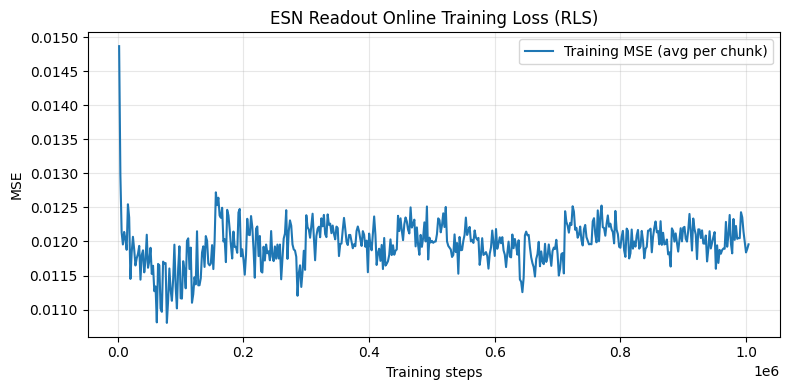


--- Testing parameters ---
n_res: 412
density: 0.00968785384837791
spectral_radius: 1.0090586160792003
alpha: 0.5435954393043274
input_scale: 1.1424844134748895
reg: 1.252876785022086
washout: 84
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3707


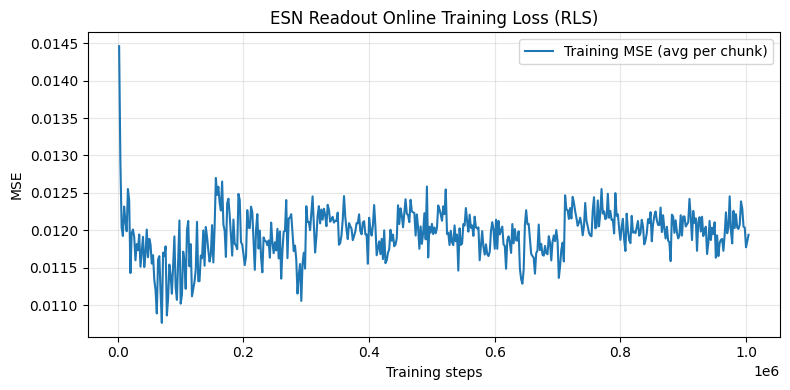


--- Testing parameters ---
n_res: 369
density: 0.005205477382825189
spectral_radius: 1.0729946688949084
alpha: 0.4527280342499228
input_scale: 0.8024212322362073
reg: 1.920300969549248
washout: 76
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3579


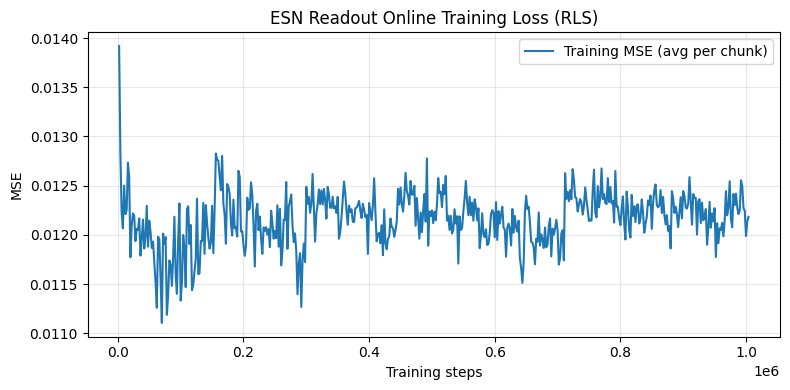


--- Testing parameters ---
n_res: 375
density: 0.014805631659179991
spectral_radius: 0.9806119221562427
alpha: 0.5488619492385753
input_scale: 0.9454390929698763
reg: 1.9390519617499837
washout: 65
include_input: False
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3613


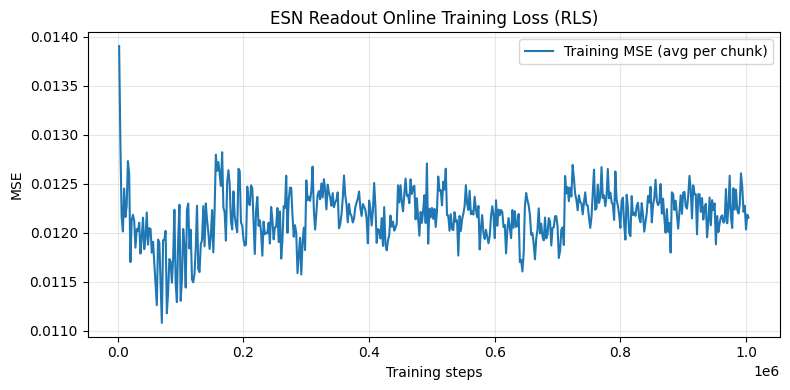


--- Testing parameters ---
n_res: 406
density: 0.013447428096827214
spectral_radius: 0.9335784183180571
alpha: 0.4281592925373335
input_scale: 0.8850556362706343
reg: 0.5087464491724151
washout: 54
include_input: False
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3569


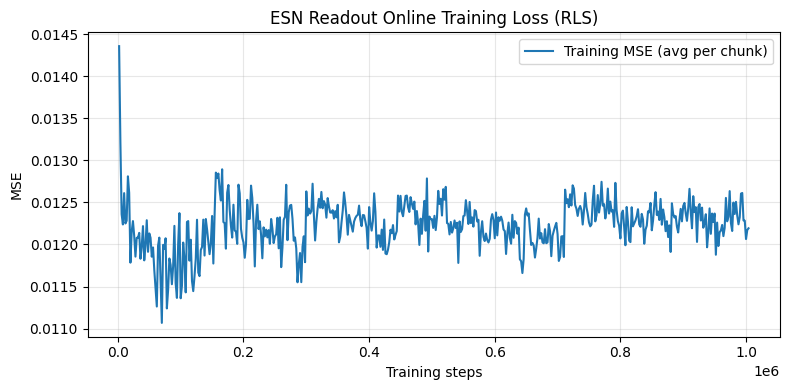


--- Testing parameters ---
n_res: 436
density: 0.01312174110368362
spectral_radius: 1.0469935374175066
alpha: 0.5847030565643702
input_scale: 0.932130867886794
reg: 0.79961601510701
washout: 169
include_input: False
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3636


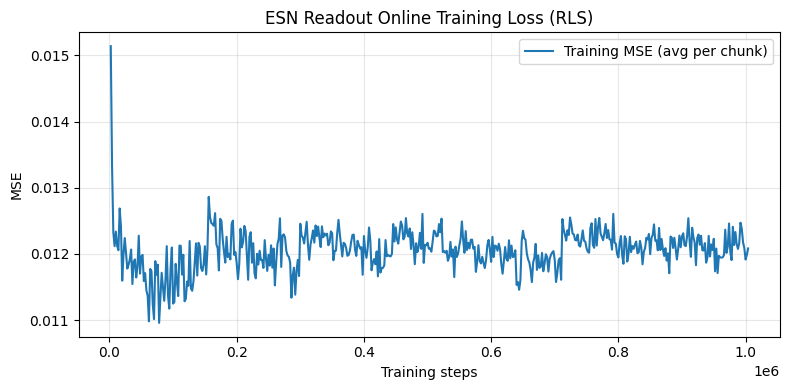


--- Testing parameters ---
n_res: 391
density: 0.01423906982442593
spectral_radius: 1.0281908101974497
alpha: 0.598595123159321
input_scale: 0.9162342186722895
reg: 1.7628344469695079
washout: 199
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3698


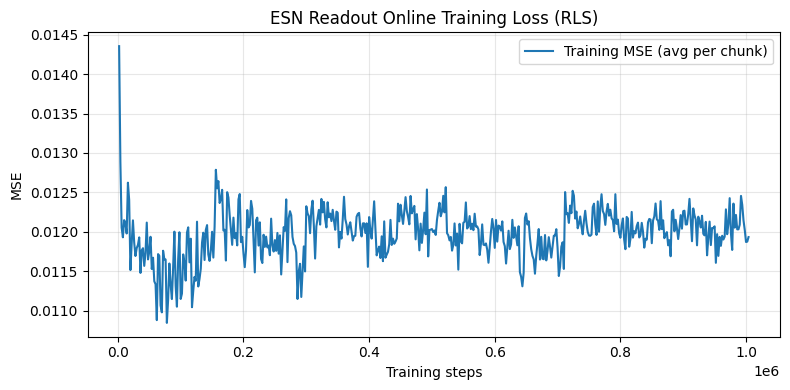


--- Testing parameters ---
n_res: 440
density: 0.013903927853626714
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 1.172342522289777
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3769


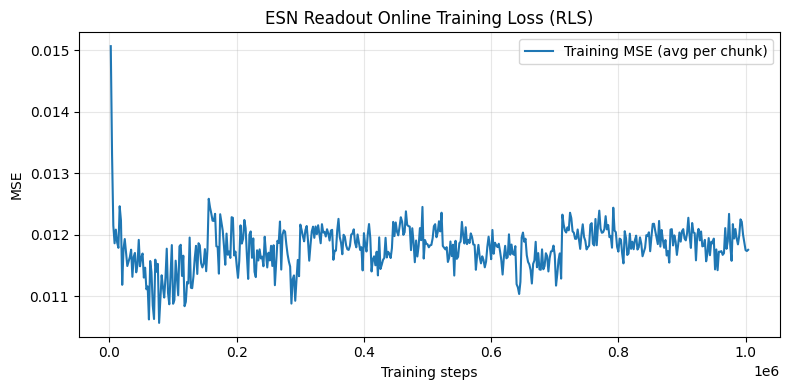


--- Testing parameters ---
n_res: 375
density: 0.007321306518465422
spectral_radius: 0.9185355122096445
alpha: 0.5165101415716256
input_scale: 1.4884096607500228
reg: 1.0025571266889757
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3651


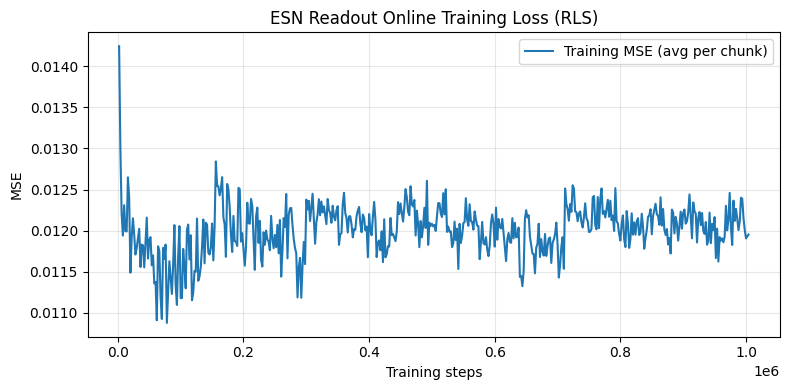


--- Testing parameters ---
n_res: 410
density: 0.011404468304989642
spectral_radius: 1.0368329245474919
alpha: 0.4548636710274459
input_scale: 0.5950463046197302
reg: 1.9926835860411283
washout: 180
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3598


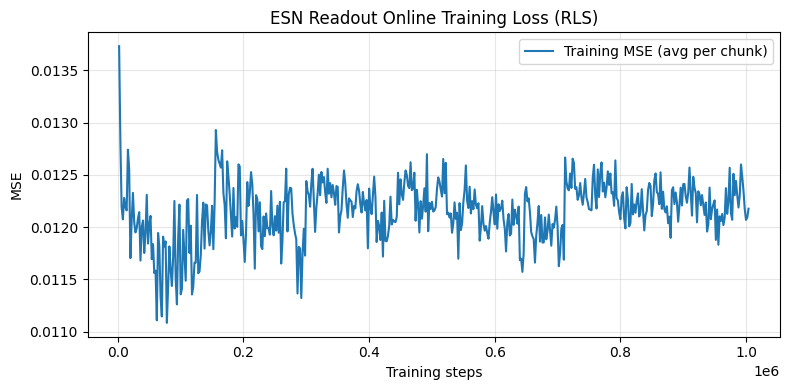

Best so far: 0.3769 with params: {'n_res': 440, 'density': 0.013903927853626714, 'spectral_radius': 1.064962442345549, 'alpha': 0.6908637028251499, 'input_scale': 1.4000351269032139, 'reg': 1.172342522289777, 'washout': 172, 'include_input': True, 'train_ratio': 0.9}

--- Generation 2/6 ---

--- Testing parameters ---
n_res: 400
density: 0.013106113093947887
spectral_radius: 1.009328712045874
alpha: 0.5394148986941762
input_scale: 1.0610543259828873
reg: 1.2581019582789914
washout: 140
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3667


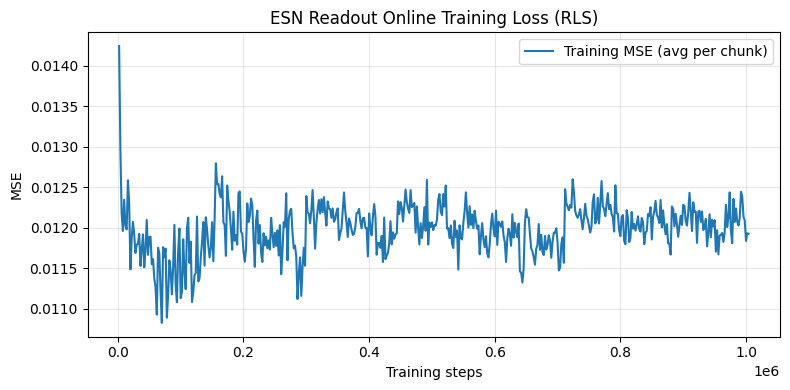


--- Testing parameters ---
n_res: 400
density: 0.012812275071380053
spectral_radius: 1.0091208042368638
alpha: 0.5622496257150815
input_scale: 1.0090447825151228
reg: 1.2971934666525935
washout: 140
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3698


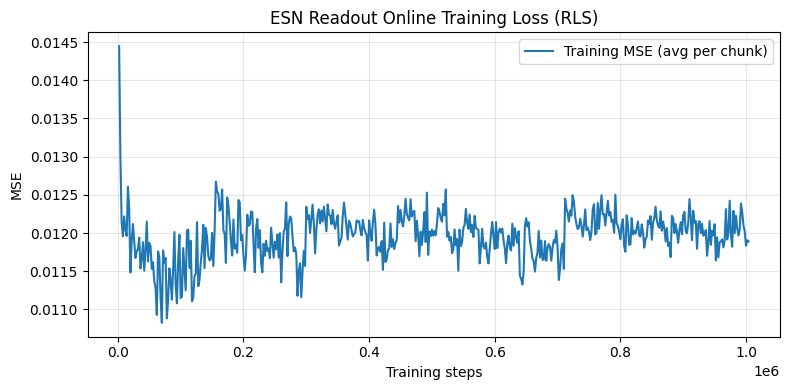


--- Testing parameters ---
n_res: 429
density: 0.007700788887983914
spectral_radius: 0.9313326315125661
alpha: 0.5201481799809299
input_scale: 1.0409528337001244
reg: 1.5919857686993666
washout: 118
include_input: False
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3648


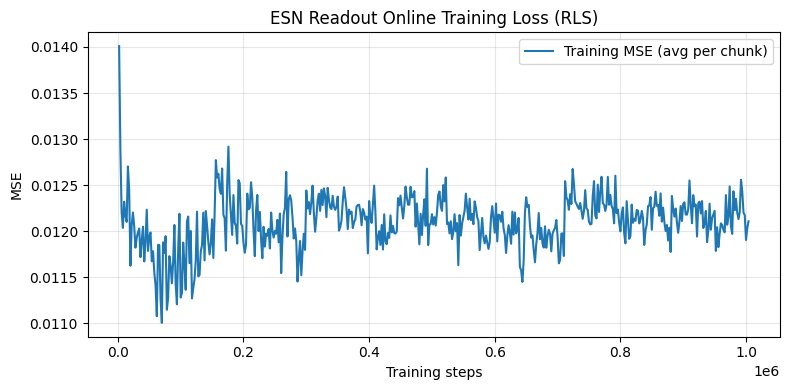


--- Testing parameters ---
n_res: 440
density: 0.013903927853626714
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.488972122088006
reg: 1.172342522289777
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3767


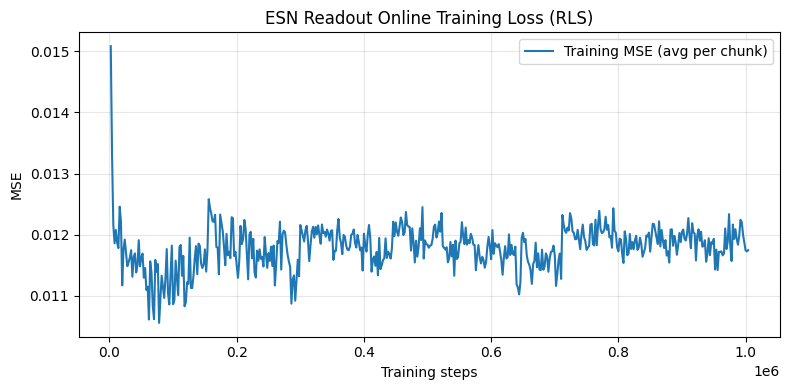


--- Testing parameters ---
n_res: 440
density: 0.008534386412664834
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.73679298674007
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3771


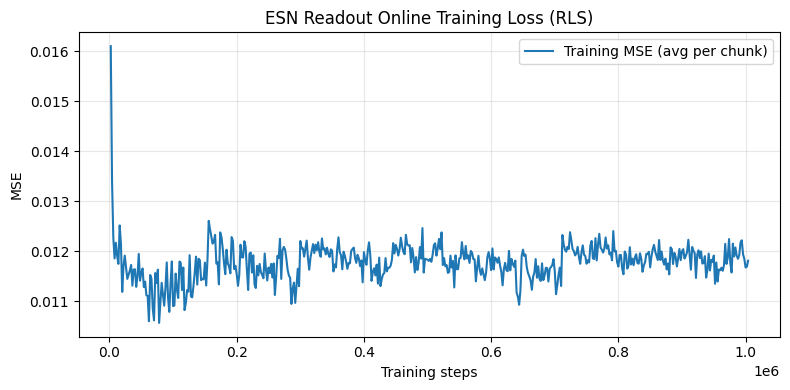


--- Testing parameters ---
n_res: 438
density: 0.013233692595149758
spectral_radius: 1.0528254250998856
alpha: 0.6048374060507506
input_scale: 1.395891784262693
reg: 1.1097329876813506
washout: 170
include_input: False
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3694


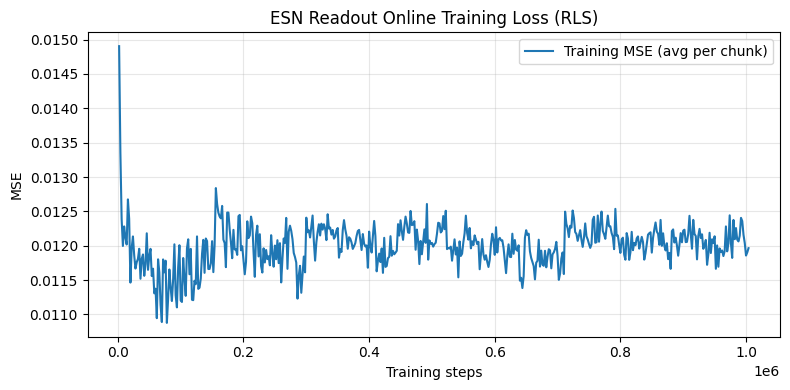


--- Testing parameters ---
n_res: 440
density: 0.013903927853626714
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 1.172342522289777
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3769


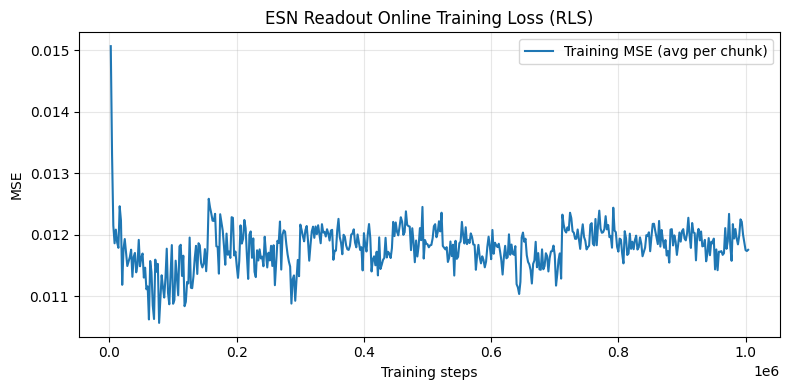


--- Testing parameters ---
n_res: 400
density: 0.014352037348681103
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 1.172342522289777
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3744


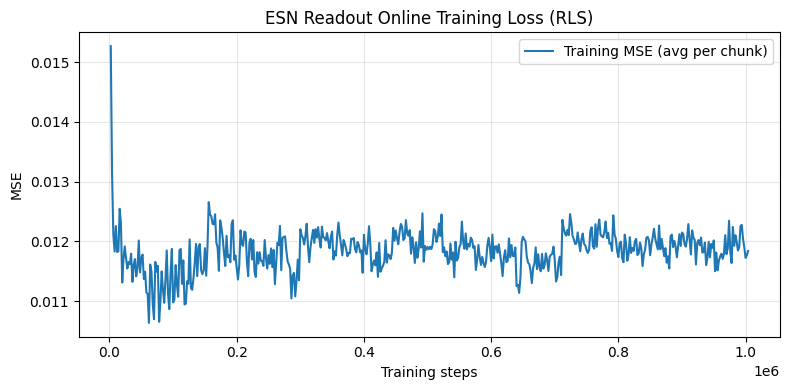


--- Testing parameters ---
n_res: 400
density: 0.013458512240766291
spectral_radius: 1.009261023854982
alpha: 0.5725891347440164
input_scale: 1.1145763946823946
reg: 1.2824777379074446
washout: 140
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3709


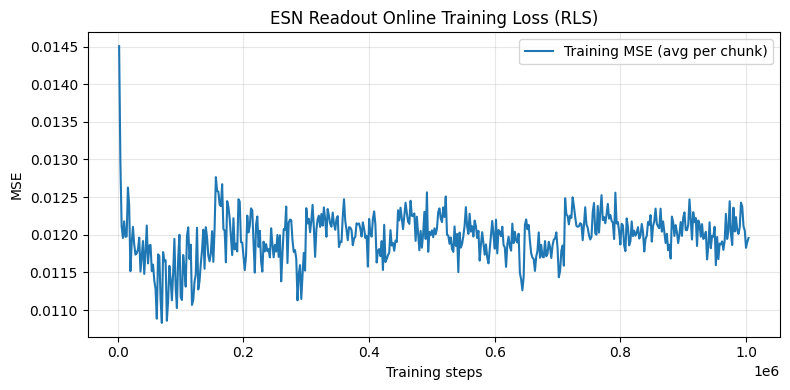


--- Testing parameters ---
n_res: 393
density: 0.007483286440345891
spectral_radius: 0.9504592548103594
alpha: 0.5428951081365344
input_scale: 1.4201295673570034
reg: 1.196349271795325
washout: 128
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3730


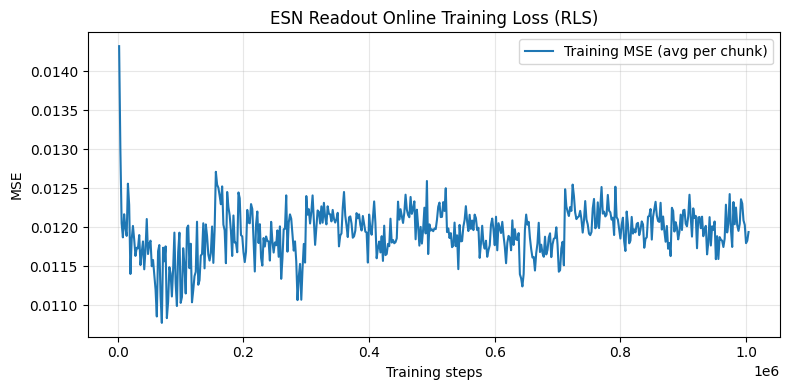

Best so far: 0.3771 with params: {'n_res': 440, 'density': 0.008534386412664834, 'spectral_radius': 1.064962442345549, 'alpha': 0.6908637028251499, 'input_scale': 1.4000351269032139, 'reg': 0.73679298674007, 'washout': 172, 'include_input': True, 'train_ratio': 0.9}

--- Generation 3/6 ---

--- Testing parameters ---
n_res: 440
density: 0.00895055928797328
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 1.090467464543143
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3800


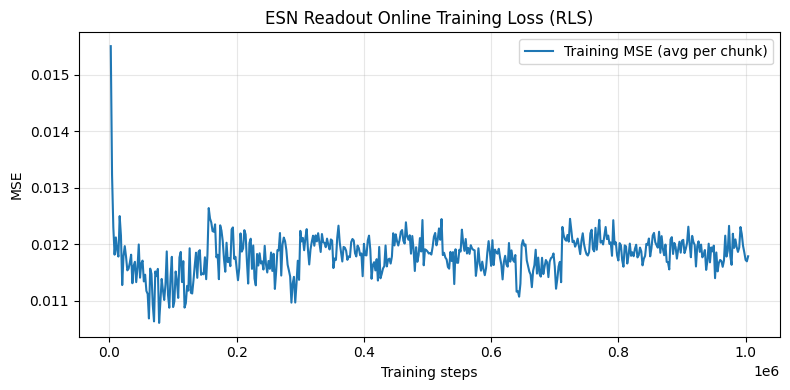


--- Testing parameters ---
n_res: 420
density: 0.014103699782385374
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 1.172342522289777
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3765


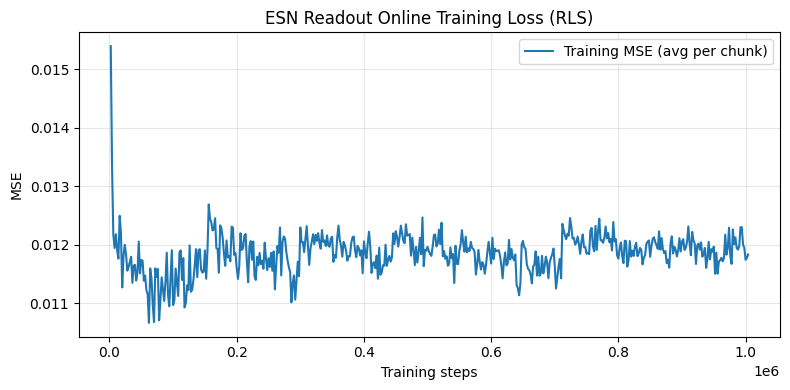


--- Testing parameters ---
n_res: 409
density: 0.0098220729995124
spectral_radius: 0.9009209901985646
alpha: 0.6521819303813069
input_scale: 1.2991068074625922
reg: 0.8774849026845586
washout: 156
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3744


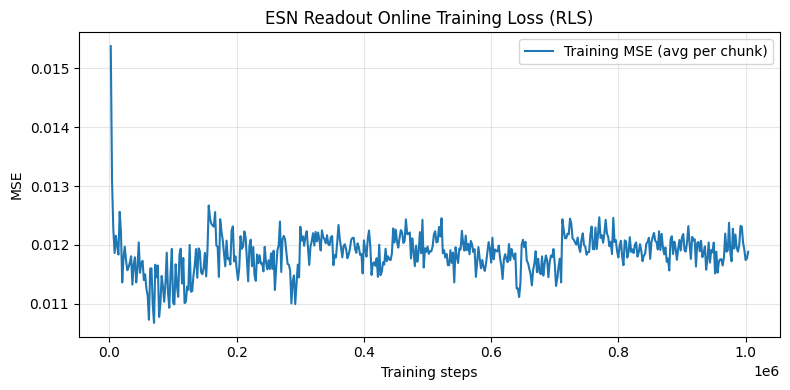


--- Testing parameters ---
n_res: 420
density: 0.008962364521153858
spectral_radius: 0.9943008494564897
alpha: 0.6744183211785348
input_scale: 1.4000351269032139
reg: 0.8907471557759872
washout: 128
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3783


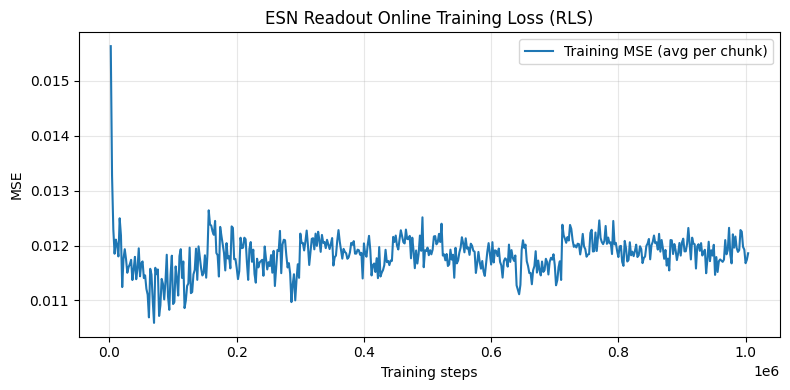


--- Testing parameters ---
n_res: 440
density: 0.009539865265512738
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.7962491470222266
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3766


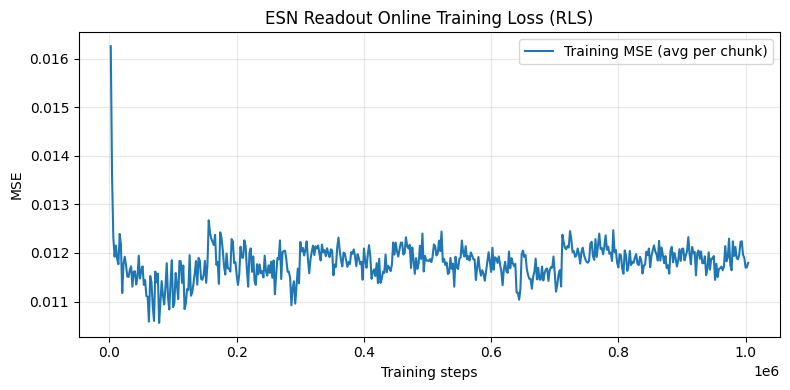


--- Testing parameters ---
n_res: 396
density: 0.009672967227854004
spectral_radius: 0.9963055043934395
alpha: 0.5883102681185924
input_scale: 1.4100596167558832
reg: 1.183417642695662
washout: 150
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3703


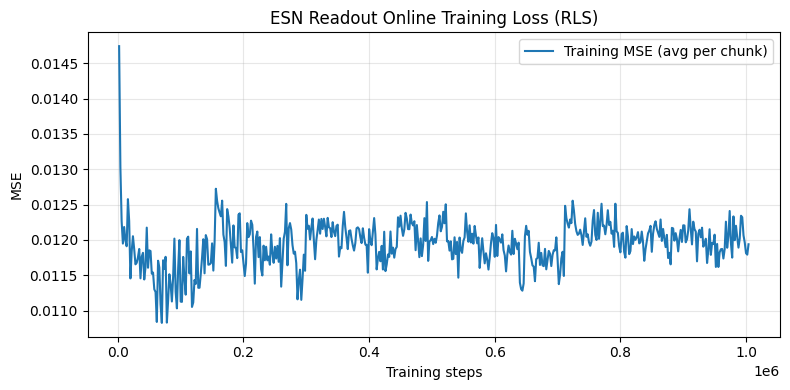


--- Testing parameters ---
n_res: 420
density: 0.014043733786526215
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 1.172342522289777
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3726


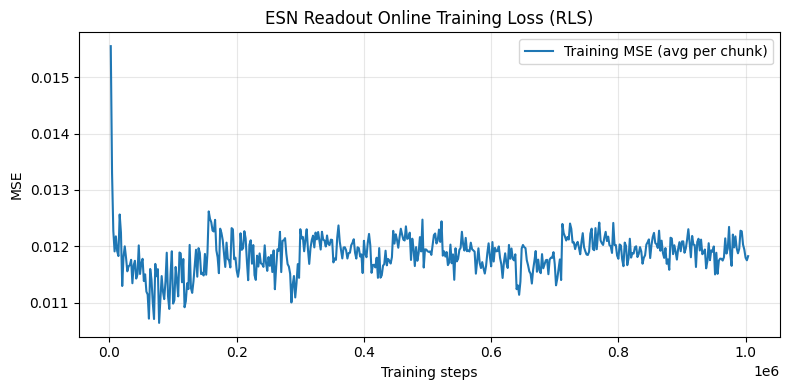


--- Testing parameters ---
n_res: 420
density: 0.01105829698576414
spectral_radius: 1.033844024750122
alpha: 0.6494616240350399
input_scale: 1.1609884640317008
reg: 1.2422045161219122
washout: 156
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3752


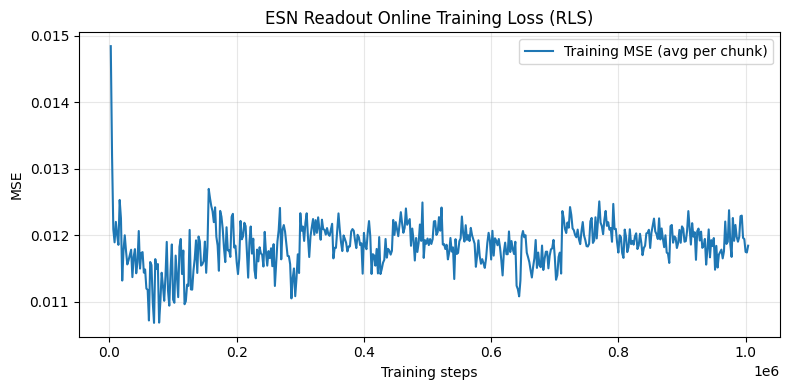


--- Testing parameters ---
n_res: 416
density: 0.013027115951482027
spectral_radius: 0.9642619588641632
alpha: 0.6289887286402838
input_scale: 1.4055492464146568
reg: 0.7908359006439144
washout: 150
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3754


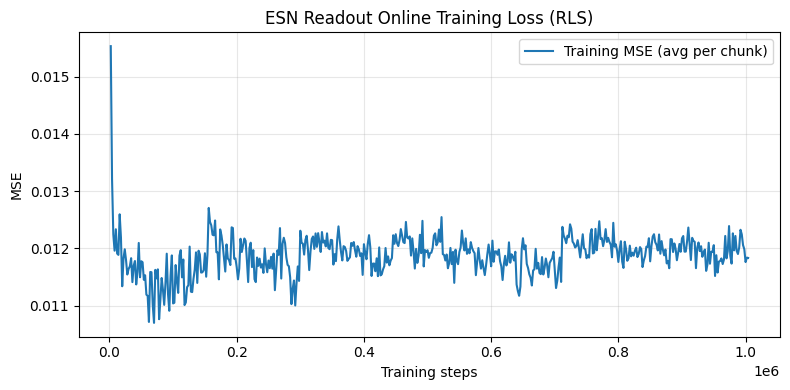


--- Testing parameters ---
n_res: 393
density: 0.010460342957392083
spectral_radius: 0.9665348266310543
alpha: 0.6717604994403208
input_scale: 1.4164102753113388
reg: 0.8984783195874342
washout: 150
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3761


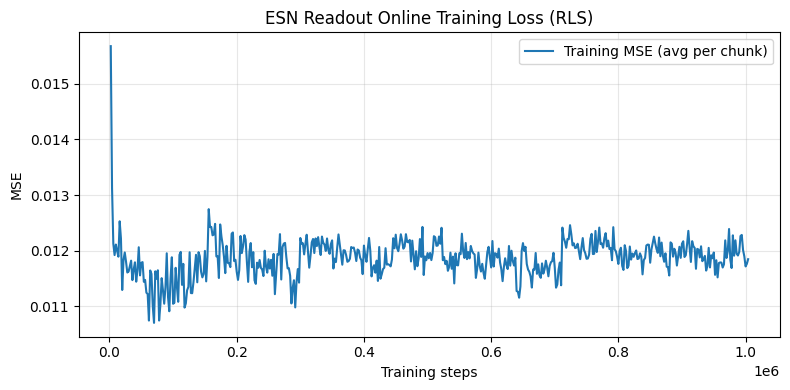

Best so far: 0.3800 with params: {'n_res': 440, 'density': 0.00895055928797328, 'spectral_radius': 1.064962442345549, 'alpha': 0.6908637028251499, 'input_scale': 1.4000351269032139, 'reg': 1.090467464543143, 'washout': 172, 'include_input': True, 'train_ratio': 0.9}

--- Generation 4/6 ---

--- Testing parameters ---
n_res: 430
density: 0.0054221654711402445
spectral_radius: 0.9417629322197834
alpha: 0.6816694575657188
input_scale: 1.4000351269032139
reg: 1.0066812406696095
washout: 80
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3767


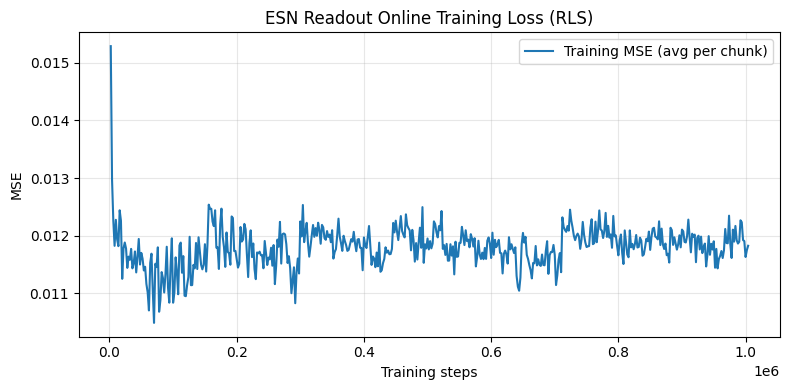


--- Testing parameters ---
n_res: 440
density: 0.009309691855377725
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.8537799253744227
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3797


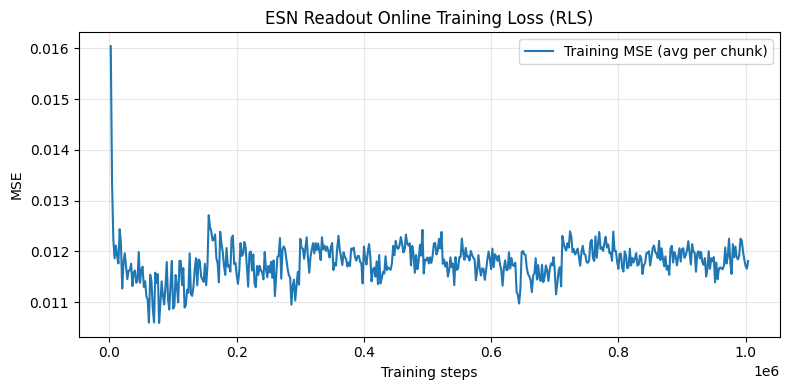


--- Testing parameters ---
n_res: 406
density: 0.011192677703168227
spectral_radius: 0.9921133697478353
alpha: 0.6748203864719262
input_scale: 1.411253944680431
reg: 1.1506121635035862
washout: 161
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3748


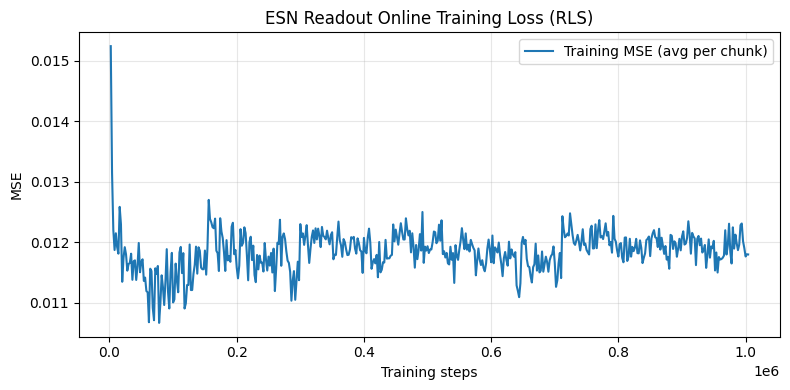


--- Testing parameters ---
n_res: 430
density: 0.010900749030832307
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 1.1149934648931097
washout: 58
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3766


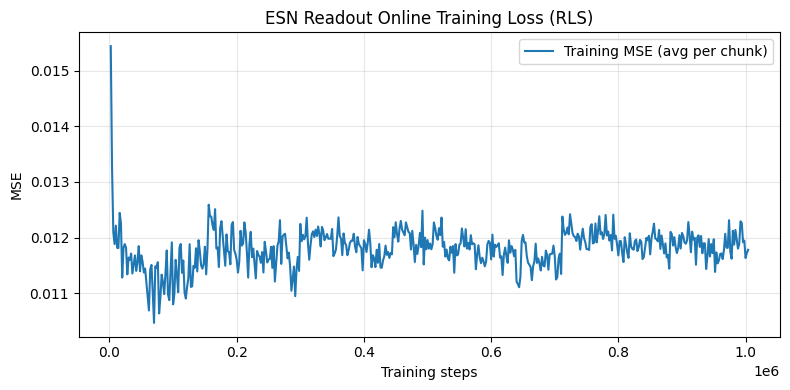


--- Testing parameters ---
n_res: 416
density: 0.009187182017964955
spectral_radius: 0.9924771697833408
alpha: 0.6735436341471326
input_scale: 1.4084735023157189
reg: 1.0358439954290626
washout: 161
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3762


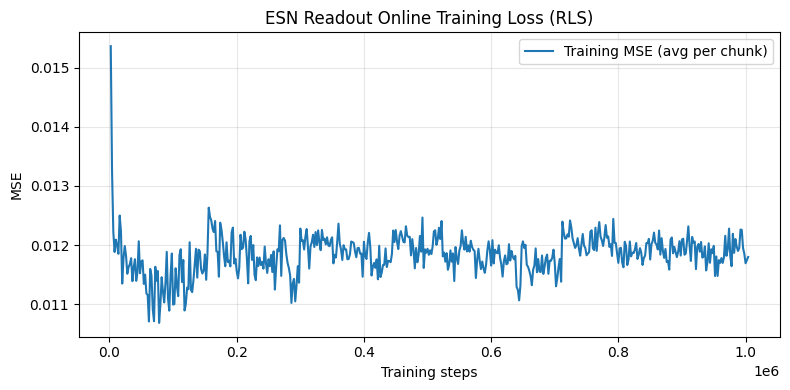


--- Testing parameters ---
n_res: 430
density: 0.009706574980935224
spectral_radius: 1.0437302503991057
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.9097357509434245
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3786


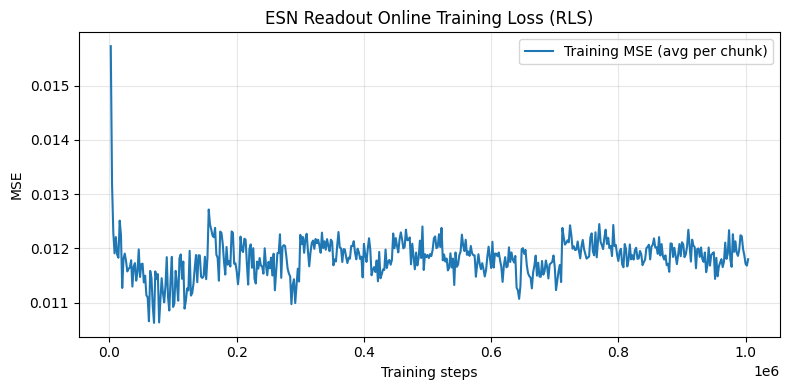


--- Testing parameters ---
n_res: 430
density: 0.008951582524575487
spectral_radius: 0.9145074206202997
alpha: 0.6827276512563882
input_scale: 1.4000351269032139
reg: 0.9991494809778001
washout: 150
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3753


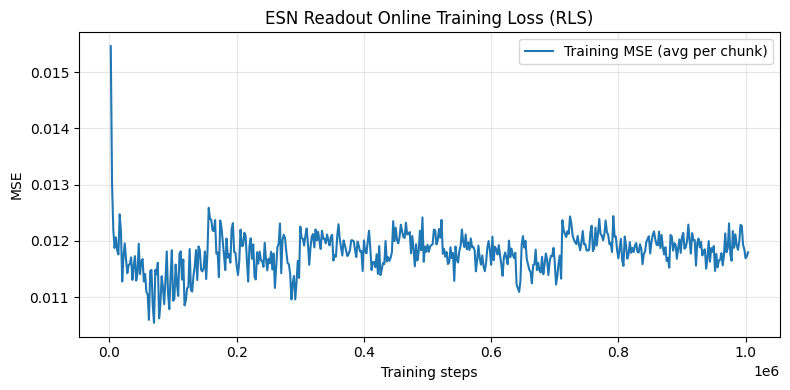


--- Testing parameters ---
n_res: 430
density: 0.008959710691771556
spectral_radius: 1.0599164011872082
alpha: 0.6878694268262109
input_scale: 1.4000351269032139
reg: 1.0403371893148727
washout: 150
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3741


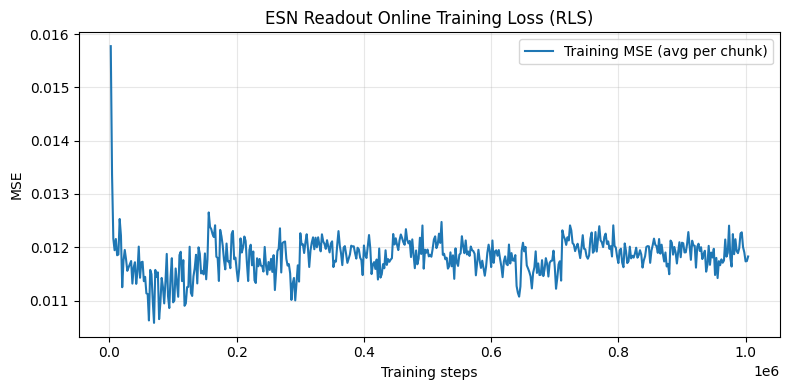


--- Testing parameters ---
n_res: 416
density: 0.010433847681758809
spectral_radius: 0.9961903136208359
alpha: 0.6864010728281382
input_scale: 1.4094703870546756
reg: 0.8205442499041004
washout: 161
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3753


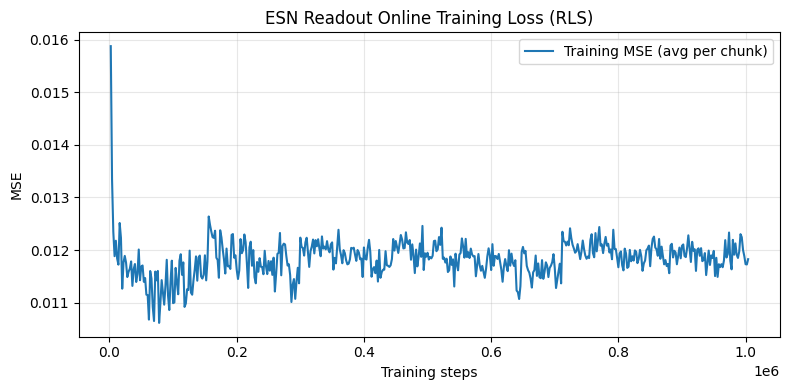


--- Testing parameters ---
n_res: 440
density: 0.00895055928797328
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 1.090467464543143
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3800


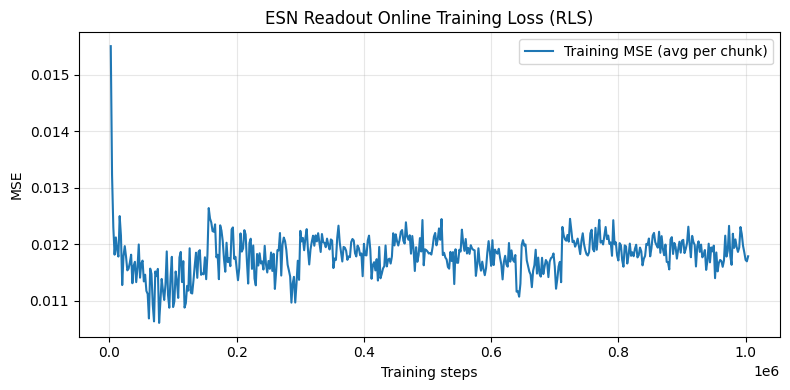

Best so far: 0.3800 with params: {'n_res': 440, 'density': 0.00895055928797328, 'spectral_radius': 1.064962442345549, 'alpha': 0.6908637028251499, 'input_scale': 1.4000351269032139, 'reg': 1.090467464543143, 'washout': 172, 'include_input': True, 'train_ratio': 0.9}

--- Generation 5/6 ---

--- Testing parameters ---
n_res: 430
density: 0.010323248029550591
spectral_radius: 1.0563607717944397
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.9376766999866151
washout: 151
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3792


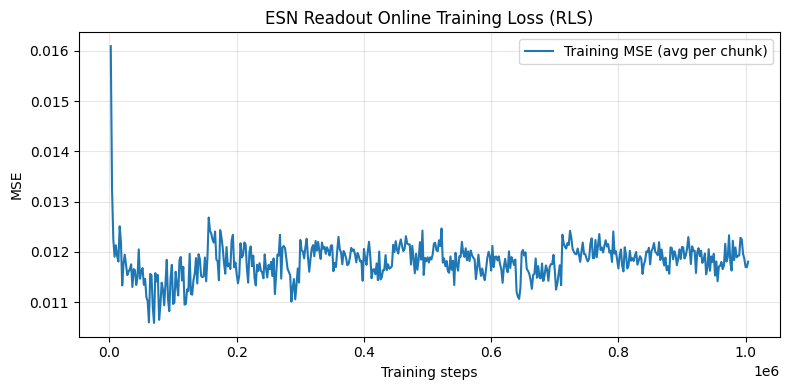


--- Testing parameters ---
n_res: 430
density: 0.006616539216886399
spectral_radius: 0.9582100521597529
alpha: 0.6855775016403064
input_scale: 1.4000351269032139
reg: 1.0049649677714383
washout: 126
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3768


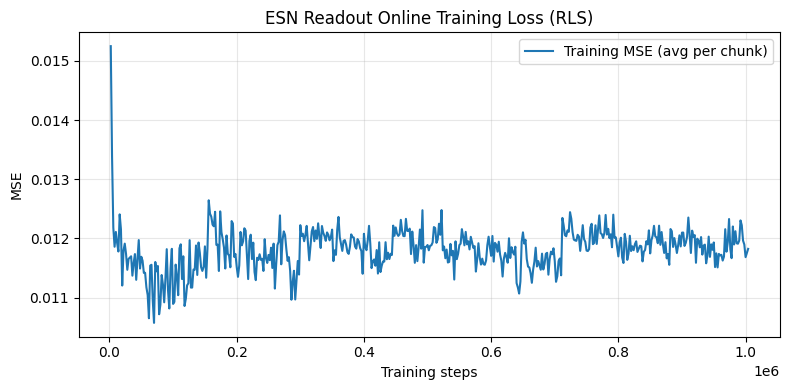


--- Testing parameters ---
n_res: 440
density: 0.009253504288796986
spectral_radius: 1.064962442345549
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.9148867655135478
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3790


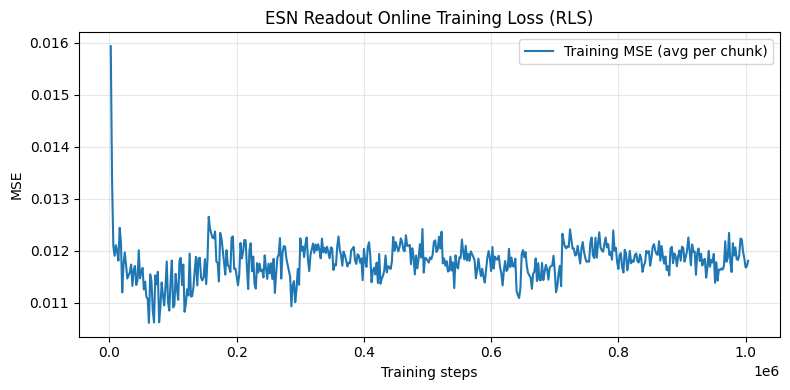


--- Testing parameters ---
n_res: 430
density: 0.010422409599305309
spectral_radius: 1.0618882896377186
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.9645560470683443
washout: 65
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3779


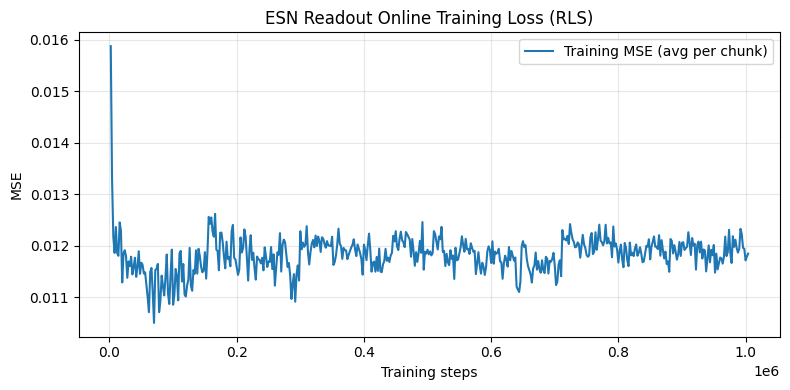


--- Testing parameters ---
n_res: 428
density: 0.009210499453500363
spectral_radius: 1.0267549933275038
alpha: 0.6847412837306686
input_scale: 1.435956641988251
reg: 0.9156545533414622
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3733


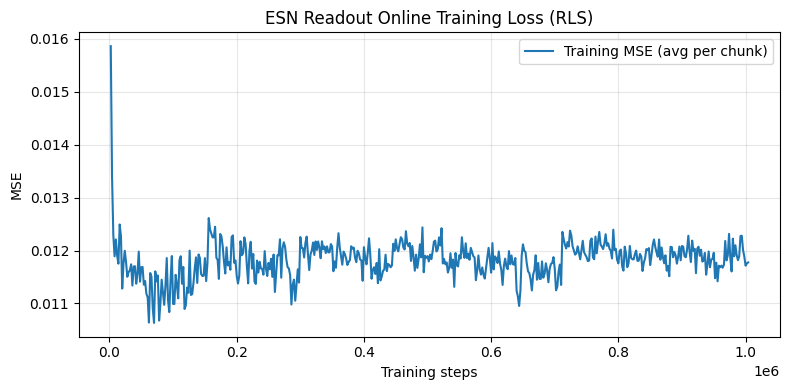


--- Testing parameters ---
n_res: 435
density: 0.009606410726092012
spectral_radius: 1.057722097743234
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.867922212167222
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3761


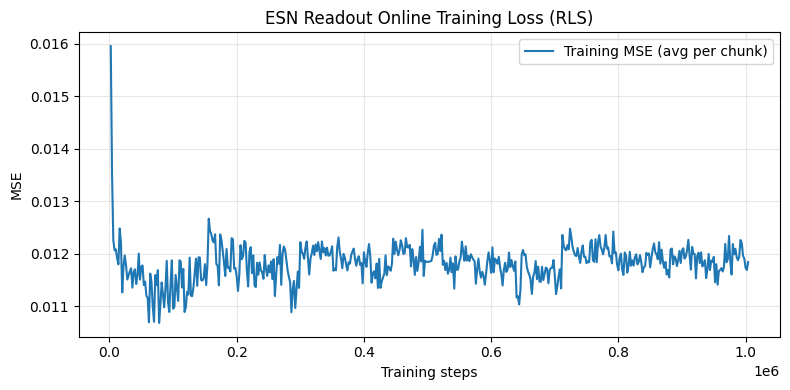


--- Testing parameters ---
n_res: 435
density: 0.009510557824250645
spectral_radius: 1.0625588109776787
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.9806419131617232
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3781


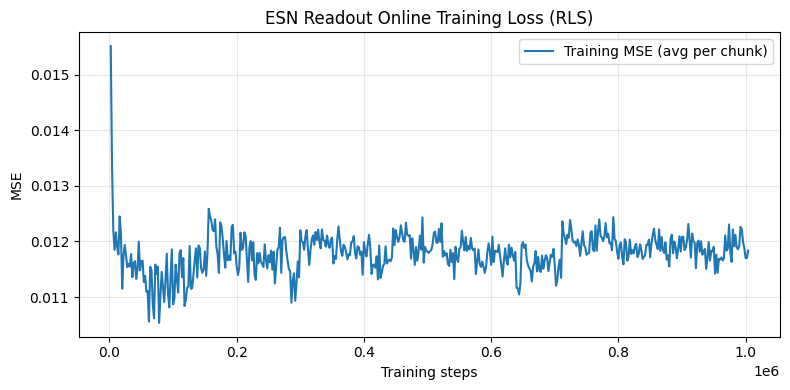


--- Testing parameters ---
n_res: 446
density: 0.009198661972961044
spectral_radius: 0.9992008896184146
alpha: 0.6899951586152183
input_scale: 1.404935196668347
reg: 0.9700236304889065
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3802


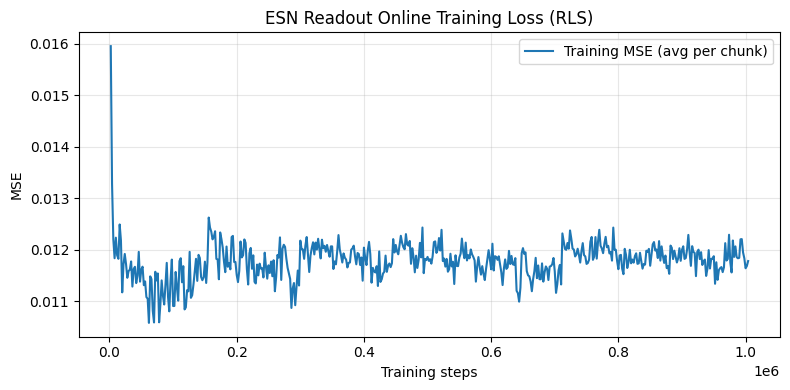


--- Testing parameters ---
n_res: 435
density: 0.009305540331049746
spectral_radius: 1.061072935025454
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.9343610320560702
washout: 172
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3742


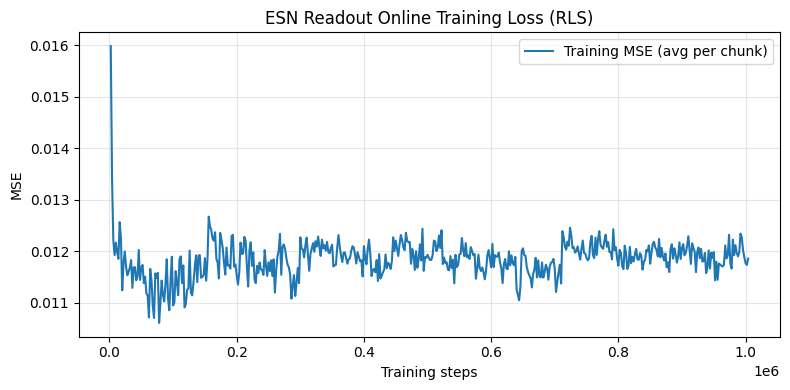


--- Testing parameters ---
n_res: 435
density: 0.006290941076381338
spectral_radius: 1.0471830637237423
alpha: 0.44875338643431945
input_scale: 0.6395970243652171
reg: 0.9278970121557889
washout: 126
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3655


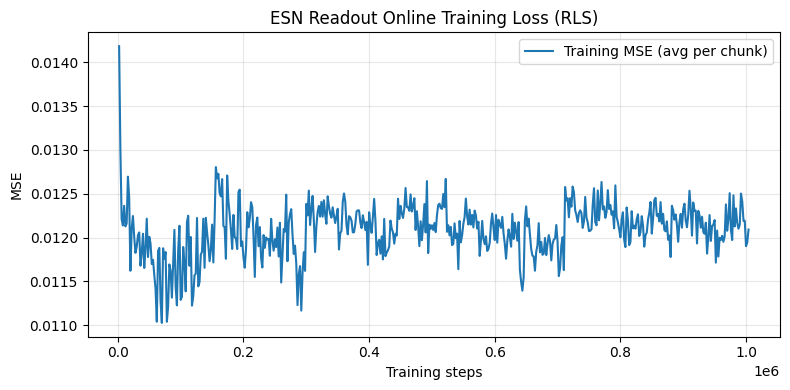

Best so far: 0.3802 with params: {'n_res': 446, 'density': 0.009198661972961044, 'spectral_radius': 0.9992008896184146, 'alpha': 0.6899951586152183, 'input_scale': 1.404935196668347, 'reg': 0.9700236304889065, 'washout': 166, 'include_input': True, 'train_ratio': 0.9}

--- Generation 6/6 ---

--- Testing parameters ---
n_res: 446
density: 0.009198661972961044
spectral_radius: 0.9992008896184146
alpha: 0.6899951586152183
input_scale: 1.404935196668347
reg: 0.9700236304889065
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3802


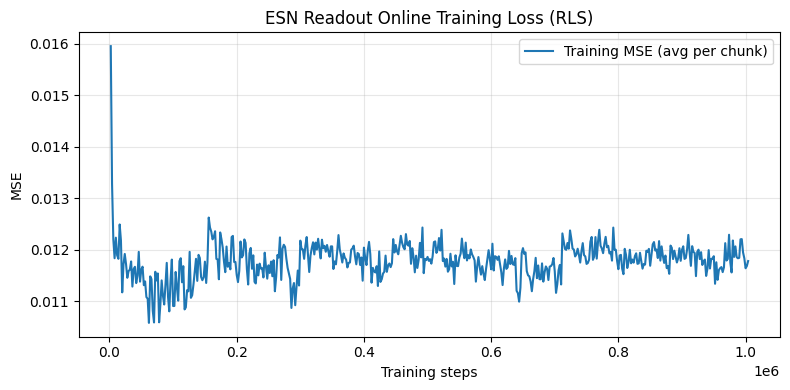


--- Testing parameters ---
n_res: 435
density: 0.01030338059199245
spectral_radius: 1.0567091767079213
alpha: 0.6908637028251499
input_scale: 1.400035126903214
reg: 0.919359473909528
washout: 161
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3764


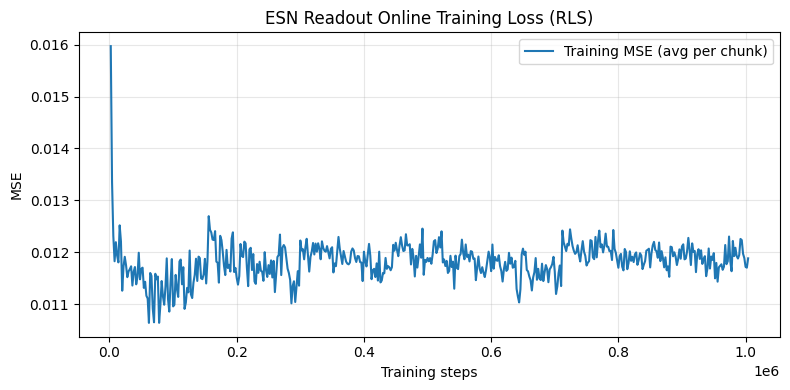


--- Testing parameters ---
n_res: 446
density: 0.009198661972961044
spectral_radius: 0.9992008896184146
alpha: 0.6899951586152183
input_scale: 1.404935196668347
reg: 0.9700236304889065
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3802


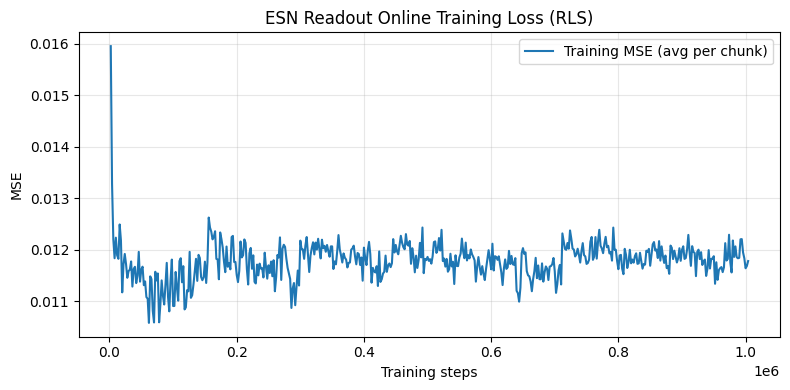


--- Testing parameters ---
n_res: 446
density: 0.009198661972961044
spectral_radius: 0.9992008896184146
alpha: 0.6899951586152183
input_scale: 1.404935196668347
reg: 0.9700236304889065
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3802


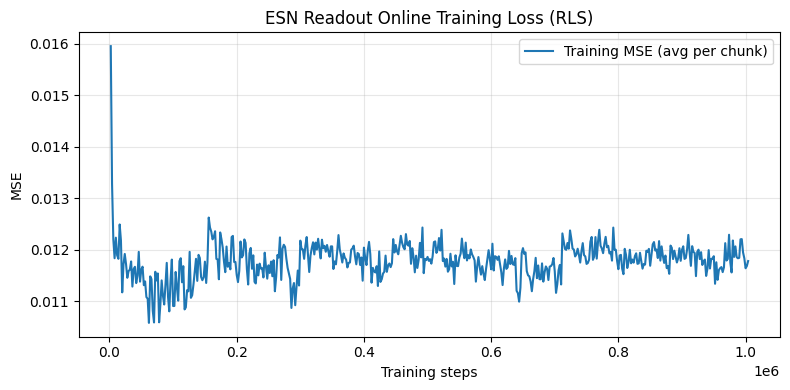


--- Testing parameters ---
n_res: 440
density: 0.009353632213263591
spectral_radius: 1.0287188753121728
alpha: 0.6903373349911104
input_scale: 1.4007262952357689
reg: 0.9766768468886755
washout: 169
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3792


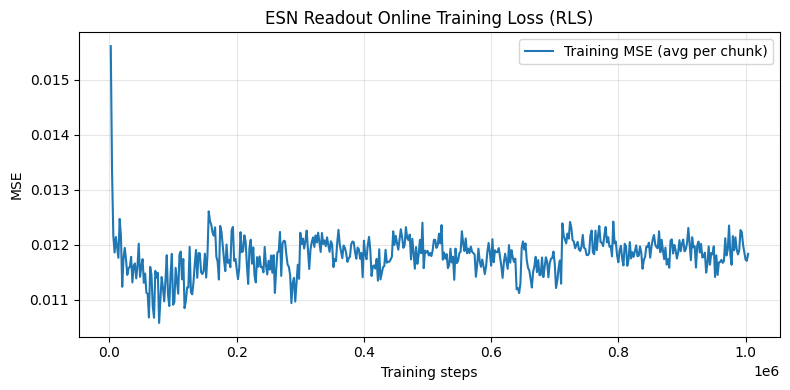


--- Testing parameters ---
n_res: 432
density: 0.009008559058244183
spectral_radius: 1.060427846476253
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.9468288560495935
washout: 161
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3766


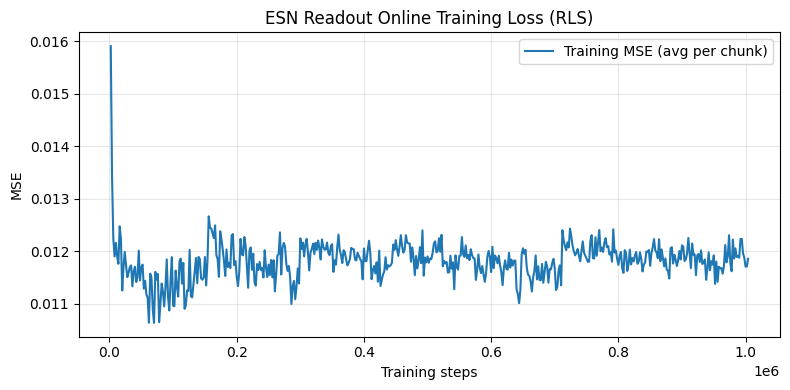


--- Testing parameters ---
n_res: 435
density: 0.010007887628246698
spectral_radius: 1.061809521721201
alpha: 0.6908637028251499
input_scale: 1.4000351269032139
reg: 0.9294969631396692
washout: 161
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3804


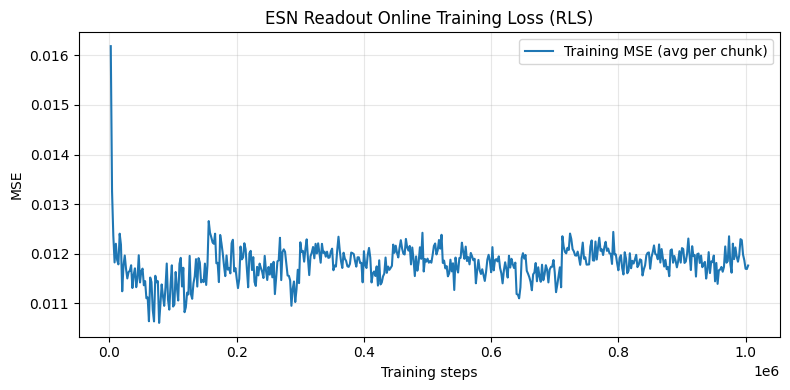


--- Testing parameters ---
n_res: 438
density: 0.008519283651959208
spectral_radius: 0.9684483990969213
alpha: 0.6857209141276456
input_scale: 1.4026103188630124
reg: 0.9867570479367898
washout: 146
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3776


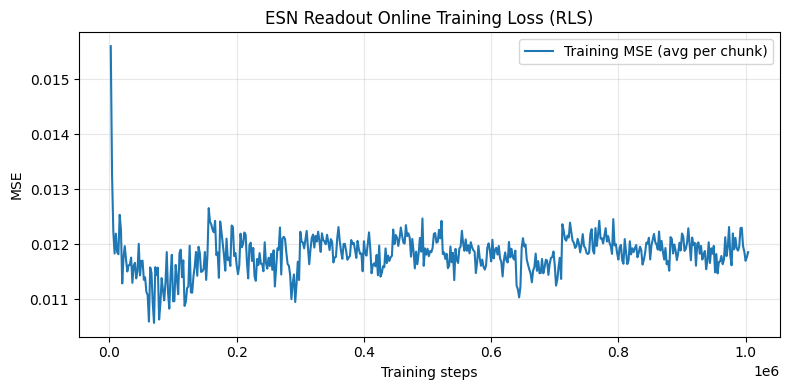


--- Testing parameters ---
n_res: 440
density: 0.009474459054119713
spectral_radius: 0.9008778860034823
alpha: 0.690707237331217
input_scale: 1.4020064393388767
reg: 0.9760186115467787
washout: 169
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3842


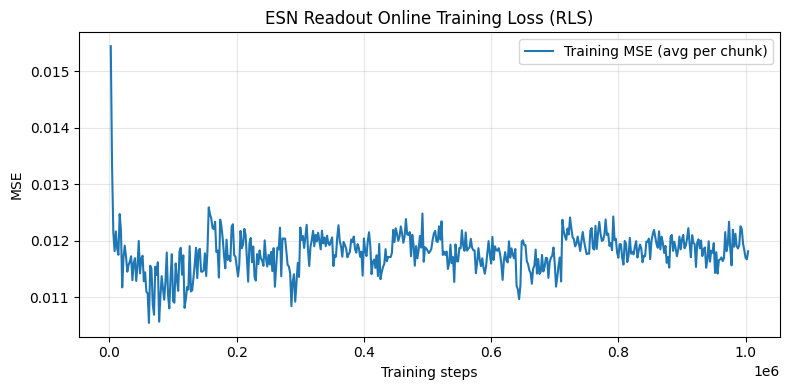


--- Testing parameters ---
n_res: 385
density: 0.009198661972961044
spectral_radius: 0.9992008896184146
alpha: 0.6899951586152183
input_scale: 1.404935196668347
reg: 0.9700236304889065
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3714


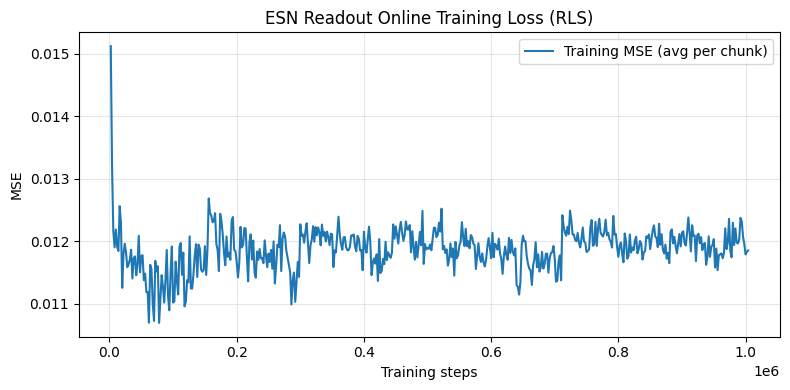

Best so far: 0.3842 with params: {'n_res': 440, 'density': 0.009474459054119713, 'spectral_radius': 0.9008778860034823, 'alpha': 0.690707237331217, 'input_scale': 1.4020064393388767, 'reg': 0.9760186115467787, 'washout': 169, 'include_input': True, 'train_ratio': 0.9}

--- Testing parameters ---
n_res: 443
density: 0.009201856202084061
spectral_radius: 1.0029236776012715
alpha: 0.6903327668163589
input_scale: 1.4014343702723304
reg: 0.9702208363258822
washout: 177
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3746


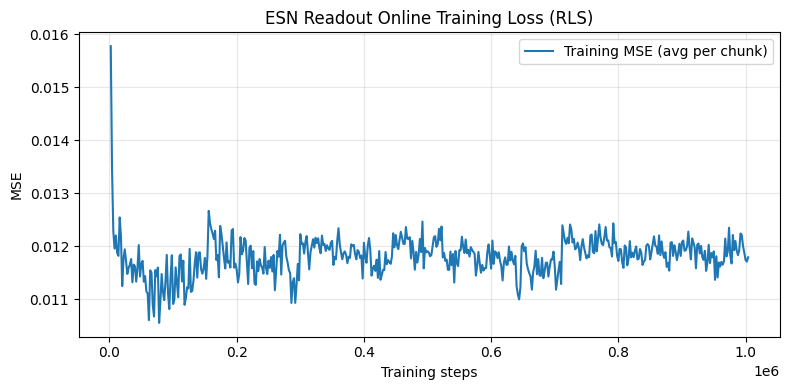


--- Testing parameters ---
n_res: 443
density: 0.009292288329631446
spectral_radius: 0.9100595566168743
alpha: 0.69014752139674
input_scale: 1.4021452802232741
reg: 1.3066373380677003
washout: 167
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3779


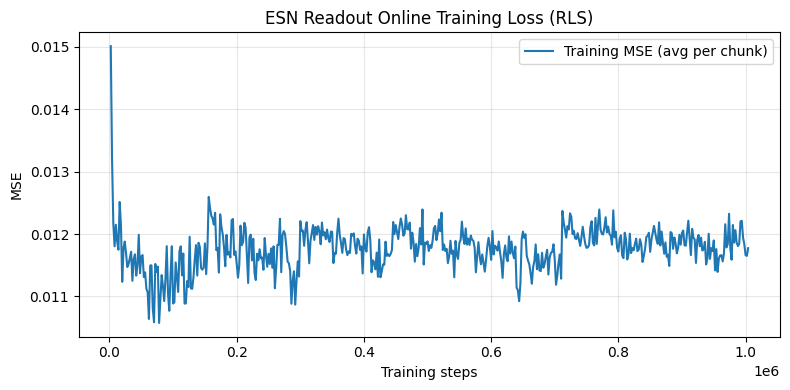


--- Testing parameters ---
n_res: 442
density: 0.010147432002148911
spectral_radius: 0.9844361404480617
alpha: 0.6859999818251306
input_scale: 1.4251523876500294
reg: 1.61506576117926
washout: 146
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3769


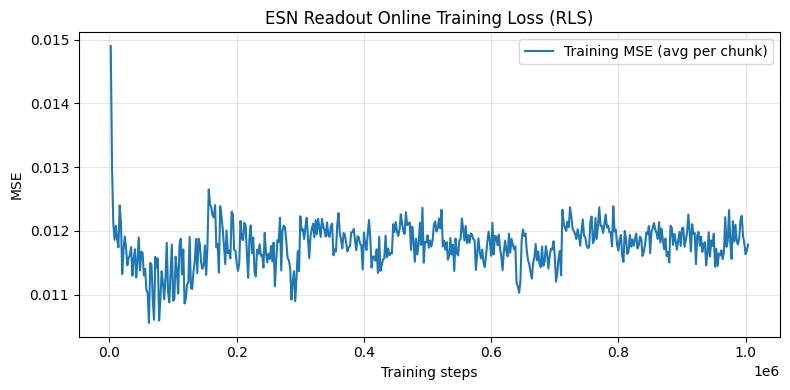


--- Testing parameters ---
n_res: 437
density: 0.009564103437764973
spectral_radius: 1.0341535378324764
alpha: 0.6904001881682964
input_scale: 1.4006226001327708
reg: 0.9633346282058077
washout: 165
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3773


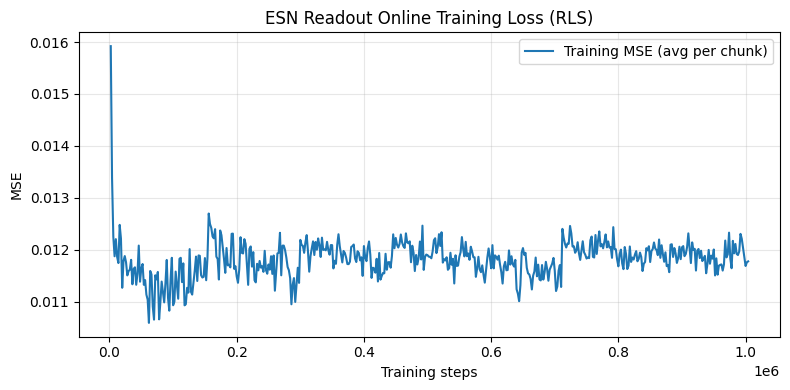


--- Testing parameters ---
n_res: 443
density: 0.009320283356263651
spectral_radius: 0.9548819679658538
alpha: 0.6901185108945751
input_scale: 1.4045121337904816
reg: 0.9746991955293479
washout: 167
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3757


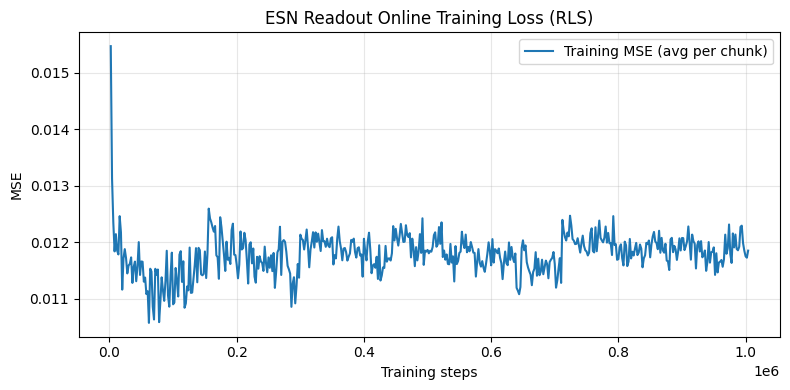


--- Testing parameters ---
n_res: 373
density: 0.009198661972961044
spectral_radius: 0.9992008896184146
alpha: 0.6899951586152183
input_scale: 1.404935196668347
reg: 0.9700236304889065
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3700


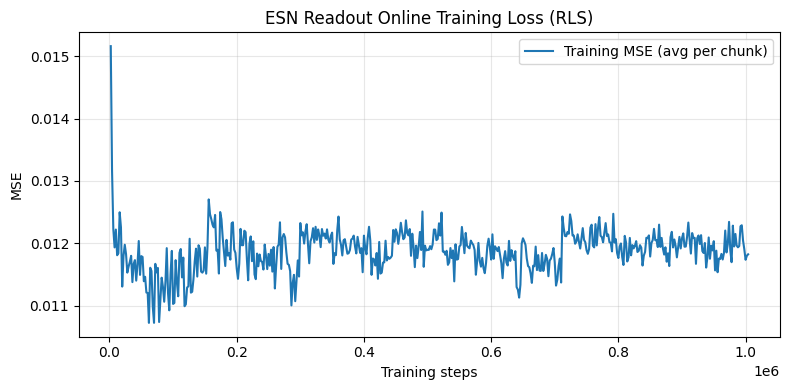


--- Testing parameters ---
n_res: 446
density: 0.009198661972961044
spectral_radius: 0.9992008896184146
alpha: 0.6899951586152183
input_scale: 1.404935196668347
reg: 0.9700236304889065
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3802


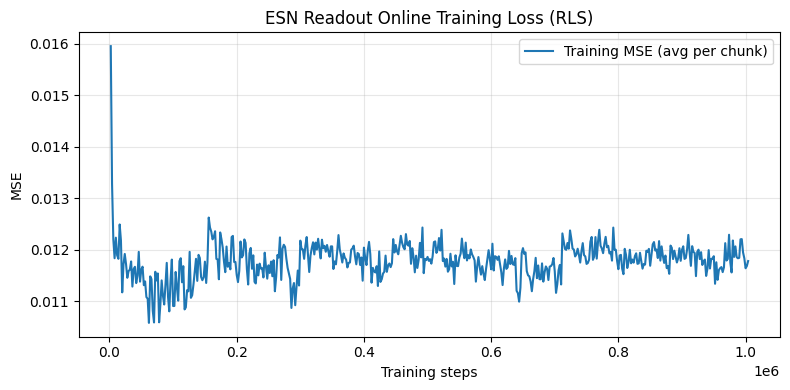


--- Testing parameters ---
n_res: 443
density: 0.009295584467819872
spectral_radius: 0.9507084346307229
alpha: 0.6904355721216587
input_scale: 1.4031447131870238
reg: 0.9735316872471302
washout: 167
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3774


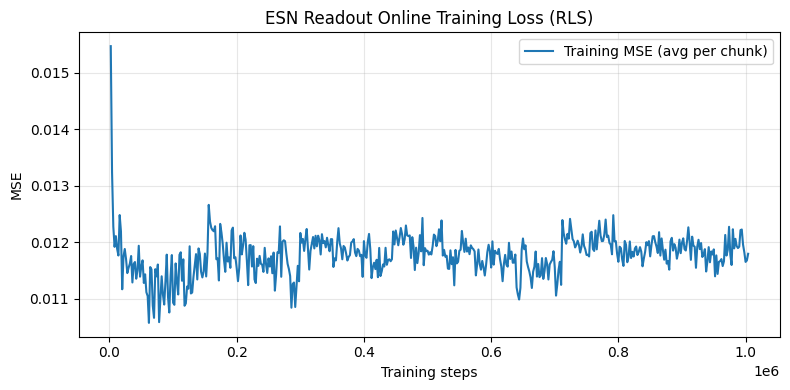


--- Testing parameters ---
n_res: 437
density: 0.010004105271117655
spectral_radius: 1.0279855495916328
alpha: 0.6908378496062758
input_scale: 1.4007871466223292
reg: 0.9689461376414163
washout: 165
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3766


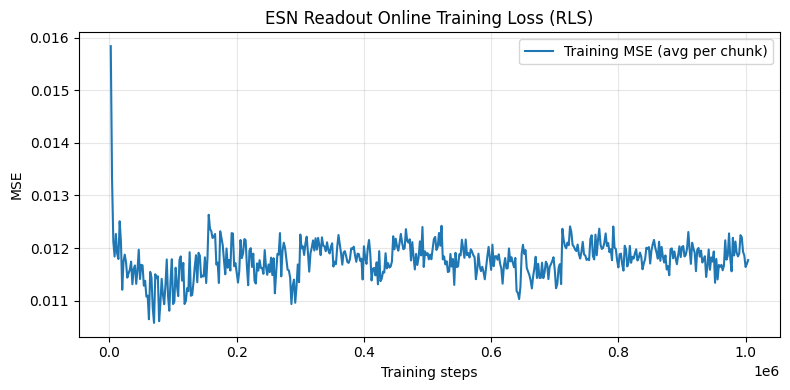


--- Testing parameters ---
n_res: 443
density: 0.009318772912281469
spectral_radius: 0.9894488049002018
alpha: 0.6900950557528032
input_scale: 1.4021567093243936
reg: 0.9755016375771175
washout: 167
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3790


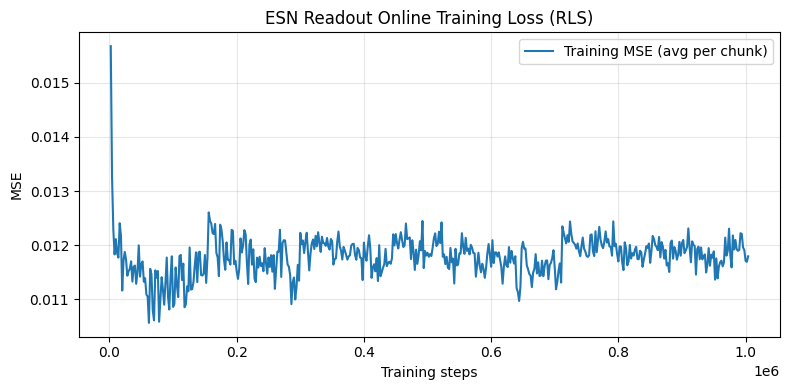


=== GA Complete ===
Best params: {'n_res': 446, 'density': 0.009198661972961044, 'spectral_radius': 0.9992008896184146, 'alpha': 0.6899951586152183, 'input_scale': 1.404935196668347, 'reg': 0.9700236304889065, 'washout': 166, 'include_input': True, 'train_ratio': 0.9}
Best test accuracy: 0.3802

Re-running with best params for final plot...

--- Testing parameters ---
n_res: 446
density: 0.009198661972961044
spectral_radius: 0.9992008896184146
alpha: 0.6899951586152183
input_scale: 1.404935196668347
reg: 0.9700236304889065
washout: 166
include_input: True
train_ratio: 0.9
-------------------------

Text length: 1115394, Vocab size: 65
Train steps: 1003853, Test steps: 111539
Test accuracy (next-char, teacher forcing): 0.3802


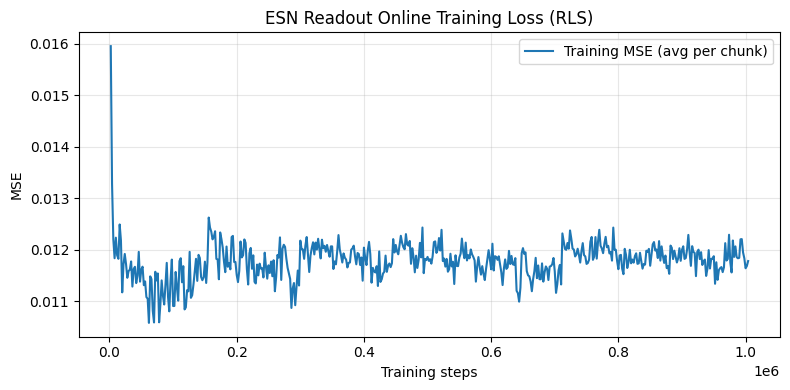

Confirmed final accuracy: 0.3802


In [12]:
# Run the GA (this will take time - each eval trains an ESN!)
# Adjust pop_size/generations if too slow (e.g., pop_size=5, generations=3 for testing)
best_params, best_acc = genetic_algorithm(pop_size=10, generations=6)

# Optional: Re-run with best params to confirm
print("\nRe-running with best params for final plot...")
final_acc = run_esn_with_params(best_params)
print(f"Confirmed final accuracy: {final_acc:.4f}")